In [ ]:
#medium.com/@ZeroVariance/predicting-house-prices-with-linear-regression-d9bb43abf7c4

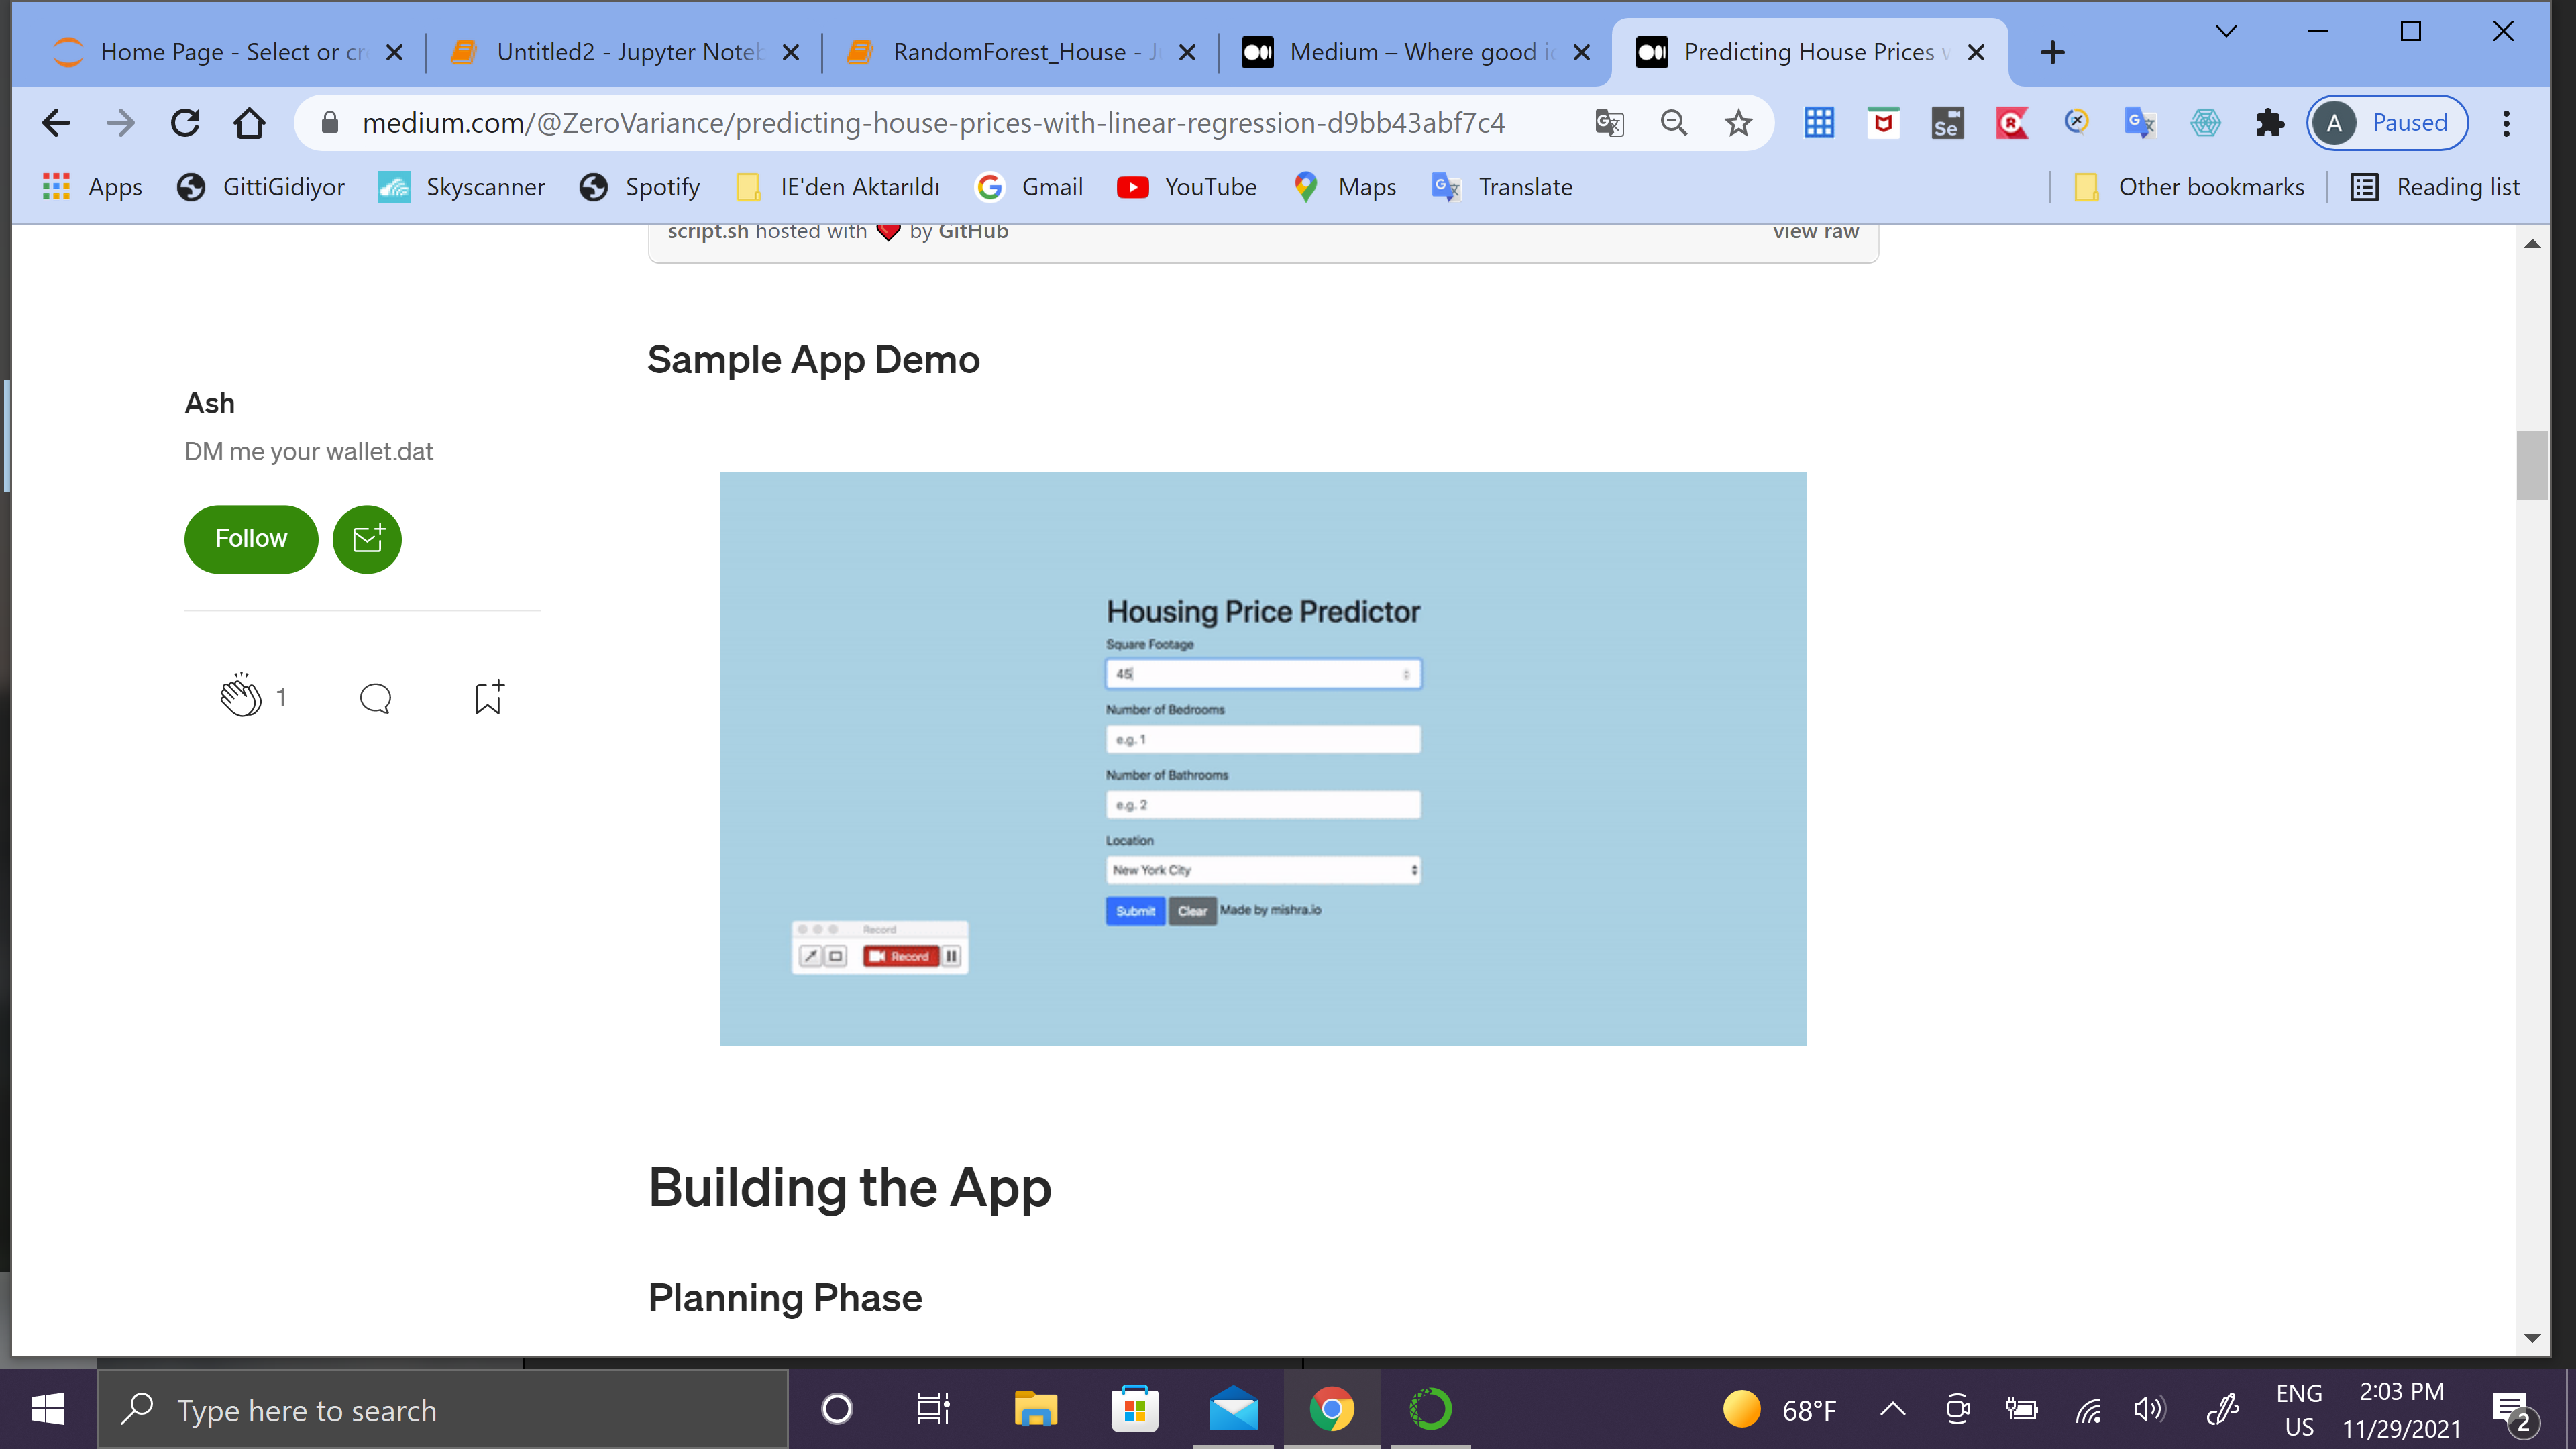

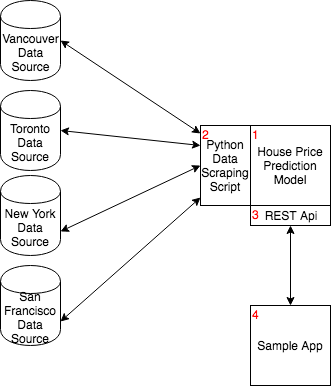

* The following is a list of all the components in Image A and their respective functionality:
* House Price Prediction Model- A Multivariate Linear Regression model written with scikit-learn that predicts home prices on the basis of size (square footage), number of bedroom(s), and number of bathroom(s).
* Data Sources- Data from 4 different websites (1 per geography) are used as training data for the model. Their contents are scraped once every 24 hours to continuously improve the model’s accuracy.
* Python Data Scraping Script- A Beautiful Soup based web-scraper configured to scrape the 4 aforementioned websites. After each scrape, data is fed into a Heroku Postgres database for persistence. The script is scheduled to run every 24 hours to continuously add new data to the database.
* REST API- An API written in Flask that allows 3rd party applications to query the ML model via a GET request.
* Sample App- A simple app created to demonstrate usage of the ML Model’s REST API.

In [ ]:
# Generates linear regression model
lin_reg = LinearRegression()
lin_reg.fit(feature_array, price_usd)

# Saves model locally
dump(lin_reg, open(f'lin_reg_model_{location.replace(" ", "_")}.pickle', "wb"))

In [ ]:
# Iterates over all listings on a given page
for listing in listings_on_page:
    try:
        # Gets the name, image link, data source, location, # of beds, # of bathrooms, square footage, and price of listing
        name = listing.find("span", {"class": "idx-address idx-address-value"}).text
        image_link = ""         # No image link
        data_source = "zephyrre"
        location = "san francisco"
        num_bed = listing.find("span", {"class": "idx-beds-value"}).text.replace(" ", "")
        num_bath = listing.find("span", {"class": "idx-baths-value"}).text.replace(" ", "")
        square_footage = listing.find("span", {"class": "listing-square-feet idx-square-feet-value"}).text.replace(" ", "").replace("\n", "").replace(",", "")
        price_usd = listing.find("span", {"class": "listing-price idx-price-value"}).text.replace(" ", "").replace(",", "")

        # If data is missing, throws exception
        if (num_bed == "") or (num_bath == "") or (square_footage == "") or (price_usd == ""):
            raise Exception

        # Makes sure current listing is't already in database
        if name not in name_list:
            all_features.append((name, image_link, data_source, location, square_footage, num_bed, num_bath, price_usd))
            name_list.append(name)

    except Exception:
        print("Error with this listing: info missing (moving to next listing)")

In [ ]:
# Inserts array of features into Heroku Postgres db
def insert_data_into_heroku_postgres(self, all_features):
    DATABASE_URL = os.environ['DATABASE_URL']
    conn = psycopg2.connect(DATABASE_URL, sslmode='require')
    cursor = conn.cursor()

    query = '''INSERT INTO residence (name, image_link, data_source, location, square_footage, num_bed, num_bath, price_usd) VALUES %s;'''
    psycopg2.extras.execute_values(cursor, query, all_features)
    conn.commit()

In [ ]:
# Prediction API
@app.route('/api/prediction', methods=['GET'])
def get_prediction():
    # Gets parameters passed in my users
    square_footage = float(request.args.get('square_footage'))
    num_bed = float(request.args.get('num_bed'))
    num_bath = float(request.args.get('num_bath'))
    location = str(request.args.get('location')).replace("-", " ")
    
    # Uses parameters to predict house's price
    predicted_usd_price = lrm.predict_price(location, [square_footage, num_bed, num_bath])[0]
    print(f"Predicted Price: {predicted_usd_price}")
    
    # Ensures that the parameters and predicted price make sense (i.e. that they aren't negative)
    if predicted_usd_price > 0 and square_footage > 0 and num_bed > 0 and num_bath > 0:
        # Formats float to dollars/cents
        predicted_usd_price = '${:,.2f}'.format(float(predicted_usd_price))
    else:
        predicted_usd_price = "N/A (please try again with different parameters)"

    # Returns predicted price as JSON
    result = {"predicted_usd_price": predicted_usd_price}
    return jsonify(result)

In [ ]:
// Sends GET request and displays response in modal
function fill_in_modal() {
    // Collects parameters
    let square_footage = $("#square_footage").val();
    let num_bed = $("#num_bed").val();
    let num_bath = $("#num_bath").val();
    let location = $("#location option:selected").text();

    // Constructs GET request with parameters
    const url = "https://model-app-314.herokuapp.com/api/prediction?square_footage="+square_footage+"&num_bed="+num_bed+"&num_bath="+num_bath+"&location="+location.split(' ').join('-').toLowerCase();

    // Sends GET request, then displays response
    $.ajax({
        url: url,
        type: "get",
        async: false,

        success: function (response) {
            let predicted_usd_price = response["predicted_usd_price"];

            $("#predicted_usd_price").text(predicted_usd_price);
        },

        error: function () {
            console.log("ERROR");
        }
    })
}